In [117]:
# Importing modules/variables
import matplotlib.pyplot as plt

import pandas as pd
import numpy
import matplotlib.colors as mcolors
import matplotlib.cm as cm

import os
import random
from collections import defaultdict

import networkx as nx
#import gensim
import umap.umap_ as umap
import umap.plot

from node2vec import Node2Vec
from gensim.models import Word2Vec

from sklearn.manifold import TSNE
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegressionCV
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler

from IPython.display import display, HTML


In [118]:
node_df = pd.read_csv("2024_05_05_meta_node_data.csv")
edge_df = pd.read_csv("2024_04_24_meta_edge_sourcetarget_disease_pub_pli_reciprocal.csv")
geneGraph = nx.DiGraph()
%run vizfunctions.ipynb

/var/folders/6q/0qnxsny943385fwzz738241c0000gn/T/ipykernel_11105/2973157215.py:2: DtypeWarning: Columns (8) have mixed types. Specify dtype option on import or set low_memory=False.
  edge_df = pd.read_csv("2024_04_24_meta_edge_sourcetarget_disease_pub_pli_reciprocal.csv")


In [119]:
#node_df.set_index('id',inplace=True)
node_df.set_index('id',inplace=True)
node_df.head()

,symbol,disease_assoc_cat,publication_count,ortholog_count,all_ortho_count
id,,,,,
7414,VCL,disease_assoc,279,5,"{'hsapien': {'entrezid': 7414, 'symbol': 'VCL'..."
4626,MYH8,disease_assoc,36,4,"{'hsapien': {'entrezid': 4626, 'symbol': 'MYH8..."
9722,NOS1AP,disease_assoc,141,5,"{'hsapien': {'entrezid': 9722, 'symbol': 'NOS1..."
9891,NUAK1,non_disease_assoc,70,5,"{'hsapien': {'entrezid': 9891, 'symbol': 'NUAK..."
81788,NUAK2,disease_assoc,46,2,"{'hsapien': {'entrezid': 81788, 'symbol': 'NUA..."


In [120]:
# Random walk (second order)

def second_order_random_walk(graph, steps, n, p, q): #graph, length of walk, number of walks per node, return probability, in-out probability
    for start_node in graph.nodes():
        for _ in range(n):  # walk iterations per node
            walk = [start_node]
            current_node = start_node
            previous_node = None
            
            while len(walk)<=steps:
            #for _ in range(steps): # length of walk
                neighbors = list(graph.neighbors(current_node))
                if not neighbors:
                    break

                if previous_node is None:
                    # First step, no previous node
                    next_node = random.choice(neighbors)
                else:
                    # Adjusting the probabilities based on the neighbors' connections to the previous node
                    probabilities = []
                    for neighbor in neighbors:
                        if neighbor == previous_node:
                            probabilities.append(1/p)#prob = graph[current_node][neighbor].get('weight', 1) / p # Incorporating edge weights into probability
                        elif graph.has_edge(previous_node, neighbor):                 # Note: there is a tradeoff between edge weights + p,q (i.e:
                            probabilities.append(1)#prob = graph[current_node][neighbor].get('weight', 1)     # if p=2, q=0.5 but the weight of the last edge is much greater,
                        else:                                                         # there is a larger probability of returning to that edge)
                            probabilities.append(1/q)#prob = graph[current_node][neighbor].get('weight', 1) / q
                        #probabilities.append(prob)

                    # Normalize probabilities
                    probabilities = numpy.array(probabilities, dtype = float)
                    probabilities /= probabilities.sum()

                    # Choose next node based on the transition probabilities
                    next_node = numpy.random.choice(neighbors, p=probabilities)

                walk.append(next_node)
                previous_node = current_node
                current_node = next_node

        return walk

def generate_random_walks(graph, steps, n, p, q): # generating random walks
    walks = []
    nodes = list(graph.nodes())
    for _ in range(n):
        random.shuffle(nodes)
        for node in nodes:
            walks.append(second_order_random_walk(graph, steps, n, p, q))
    return walks

In [121]:
# # Creating the graph
# create_graph(5000)
# degrees = geneGraph.degree()
# degree_dict = {}
# # Finding degree of each node
# for pair in degrees:
#     node, degree = pair
#     degree_dict[node] = degree

# # Sorting nodes by degree
# sorted_nodes = dict(sorted(degree_dict.items(), key=lambda item: item[1], reverse=True))
# nodes = [node for node, degree in sorted_nodes.items()]

In [122]:
# print("Number of isolated nodes:", len(list(nx.isolates(geneGraph))))


In [129]:
# 1048576
create_graph(1500)

walks = generate_random_walks(geneGraph, 500, 10, 0.5, 0.5)
print(f"Number of random walks: {len(walks)}")

all_lengths = []
for walk in walks:
    walk_length = len(walk)
    all_lengths.append(walk_length)

print(f'The longest walk is {max(all_lengths)} steps')

Number of random walks: 6120
The longest walk is 6 steps


In [130]:
# Converting every int node to str because Word2Vec requires strings
str_walks = [[str(n) for n in walk] for walk in walks]

# Using Word2Vec to embed vectors into nodes
model = Word2Vec(str_walks, vector_size=128, window=5, min_count=0, sg=0, workers=2, hs=0, epochs=1)
# Can print node embedding vector using model.wv with node ID as key
# model.wv["7414"].shape

In [125]:
#Finding visited nodes
node_paths = set()
for path in walks:
    for step in path:
        if step not in node_paths:
            node_paths.add(step)

visited_nodes = list(node_paths)


In [126]:
# Coloring nodes

# THREE COLORS

# Creating a dictionary that assigns nodes to their disease association in a dict

disease_cat_dict = {}
for node in visited_nodes:
    disease_assoc_cat = node_df.loc[node]['disease_assoc_cat']
    if disease_assoc_cat == 'disease_assoc':
        disease_cat_dict[node] = {'category':'disease_assoc'}
    elif disease_assoc_cat == 'non_disease_assoc':
        disease_cat_dict[node] = {'category':'non_disease_assoc'}
    elif disease_assoc_cat == 'non_omim':
        disease_cat_dict[node] = {'category':'non_omim'}
    else:
        print ('failed')

# Assigning the attrubutes to the nodes
nx.set_node_attributes(geneGraph, disease_cat_dict)

# Creating a color map for the categories to colors
node_color_map = {'disease_assoc':'tab:red','non_disease_assoc':'tab:blue','non_omim':'gray'}
node_colors = [node_color_map[disease_cat_dict[node]['category']] for node in visited_nodes]
node_colors_array = numpy.array(node_colors)

In [127]:
# COLOR SPECTRUM
# Nodes color spectrum based on publication count

# Map values to colors based on color map
def get_colors(nodes, cmap):
    if not nodes:
        return {}
    values = list(nodes.values())
    norm = mcolors.Normalize(vmin=min(numpy.log1p(values)), vmax=max(numpy.log1p(values)))   # normalizing all values on a scale of 0 to 1 for coloring
    cmap = cm.get_cmap(cmap)
    return {node: cmap(norm(value)) for node, value in nodes.items()}

# Apply colormap to each category's nodes and collect colors
# Creating a dict and storing all genes
disease_assoc = {}
non_disease_assoc = {}
non_omim = {}
for node in visited_nodes:
    disease_cat = node_df.loc[node]['disease_assoc_cat']
    if disease_cat == 'disease_assoc':
        disease_assoc[node] = node_df.loc[node]['publication_count']
    elif disease_cat == 'non_disease_assoc':
        non_disease_assoc[node] = node_df.loc[node]['publication_count']
    elif disease_cat == 'non_omim':
        non_omim[node] = node_df.loc[node]['publication_count']
# Identifying base colors for each category
base_colors = {'disease_assoc':'Reds', 'non_disease_assoc':'Blues', 'non_omim': 'Grays', 1:'Grays'}

# Mapping the categories to each other to normalize
all_nodes = {'disease_assoc': disease_assoc,'non_disease_assoc': non_disease_assoc, 'non_omim': non_omim}

# Storing node colors in a list
node_colors_spectrum = []
for category, nodes in all_nodes.items():
    if category not in base_colors:
        print(f"Category {category} is not in base colors")
    else:
        cmap_name = base_colors[category]
        colors = get_colors(nodes, cmap_name)
        if category == 'unknown':
            colors = {node: (0, 0, 0, 1) for node in nodes} # Making 'unknown' nodes black
        node_colors_spectrum.extend(colors[node] for node in visited_nodes if node in colors)
node_colors_spectrum_array = numpy.array(node_colors_spectrum)

/var/folders/6q/0qnxsny943385fwzz738241c0000gn/T/ipykernel_11105/34090372.py:10: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap(cmap)


In [133]:
import umap.umap_ as umap
# Retrieve node embeddings and corresponding subjects
node_embeddings = (model.wv.vectors)  # numpy.ndarray of node vectors
node_ids = list(model.wv.index_to_key) # list of node IDs


int_node_ids = []
for node_id in node_ids:
    int_node_ids.append(int(node_id))
int_node_ids = numpy.array(int_node_ids)

print(len(node_embeddings))
print(len(int_node_ids))

# # Apply t-SNE transformation on node embeddings
# tsne = TSNE(n_components=2)
# tsne_node_embeddings_2d = tsne.fit_transform(node_embeddings)

# Apply UMAP transformation on node embeddings (dimensionality reduction)
umap_embeddings_2d = umap.UMAP(n_neighbors=80, min_dist=0.25, n_components=2, metric='euclidean').fit_transform(node_embeddings)

# (These embeddings are for the umap.plot)
umap_embeddings_plot = umap.UMAP(n_neighbors=200, min_dist=.01, n_components=2, metric='euclidean').fit(node_embeddings)

# Extracting vector and corresponding node
umap_embeddings = {node_ids[i]: tuple(umap_embeddings_2d[i]) for i in range(len(node_ids))}

73
73


/Users/anusha/Desktop/Neuroinformatics_Internship/HopkinsGeneClassificationProj/env/lib/python3.12/site-packages/umap/umap_.py:2437: UserWarning: n_neighbors is larger than the dataset size; truncating to X.shape[0] - 1
  warn(
/Users/anusha/Desktop/Neuroinformatics_Internship/HopkinsGeneClassificationProj/env/lib/python3.12/site-packages/umap/umap_.py:2437: UserWarning: n_neighbors is larger than the dataset size; truncating to X.shape[0] - 1
  warn(


/Users/anusha/Desktop/Neuroinformatics_Internship/HopkinsGeneClassificationProj/env/lib/python3.12/site-packages/umap/plot.py:441: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax.scatter(


<Axes: >

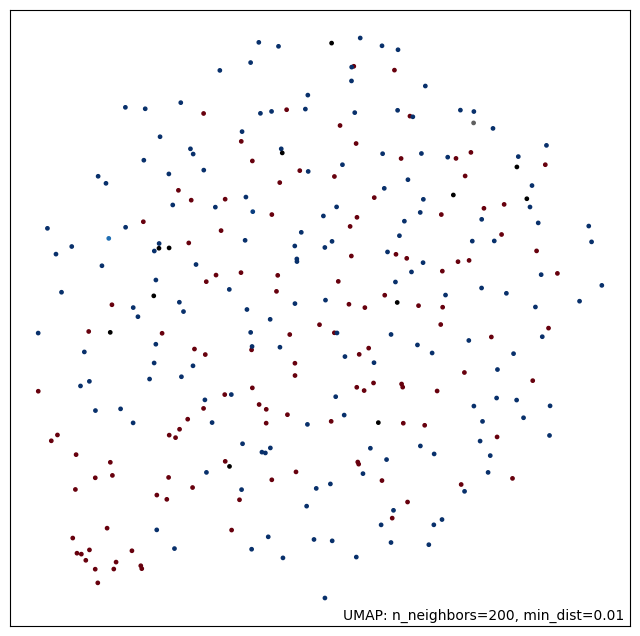

In [58]:
# Plotting using umap.plot
import umap.plot
umap.plot.points(umap_embeddings_plot, values=node_colors_spectrum_array)
#umap.plot.connectivity(umap_embeddings_plot, show_points=True)

In [31]:
# Check if lengths match
print(len(geneGraph.nodes()))
print(len(node_colors))
print(len(node_embeddings))
print(len(node_colors_spectrum))

1462
1462
1462
1462


In [ ]:
# Making the plot interactive
import umap.plot

index_array = numpy.array(node_df.index)

# Creating interactive categories
hover_data = pd.DataFrame({'gene id':index_array, 'gene name':node_df['symbol'].values, 'publication count': node_df['publication_count'].values, 'ortholog count': node_df['ortholog_count'].values, 'disease association':node_df['disease_assoc_cat'].values})

node_colors_rgb = [color[:1] for color in node_colors_spectrum_array]  # Take only R, G, B components

umap.plot.output_notebook()
p = umap.plot.interactive(umap_embeddings_plot, labels=node_colors_array, hover_data=hover_data, point_size=2)
umap.plot.show(p)

Loading BokehJS ...

4100
4100


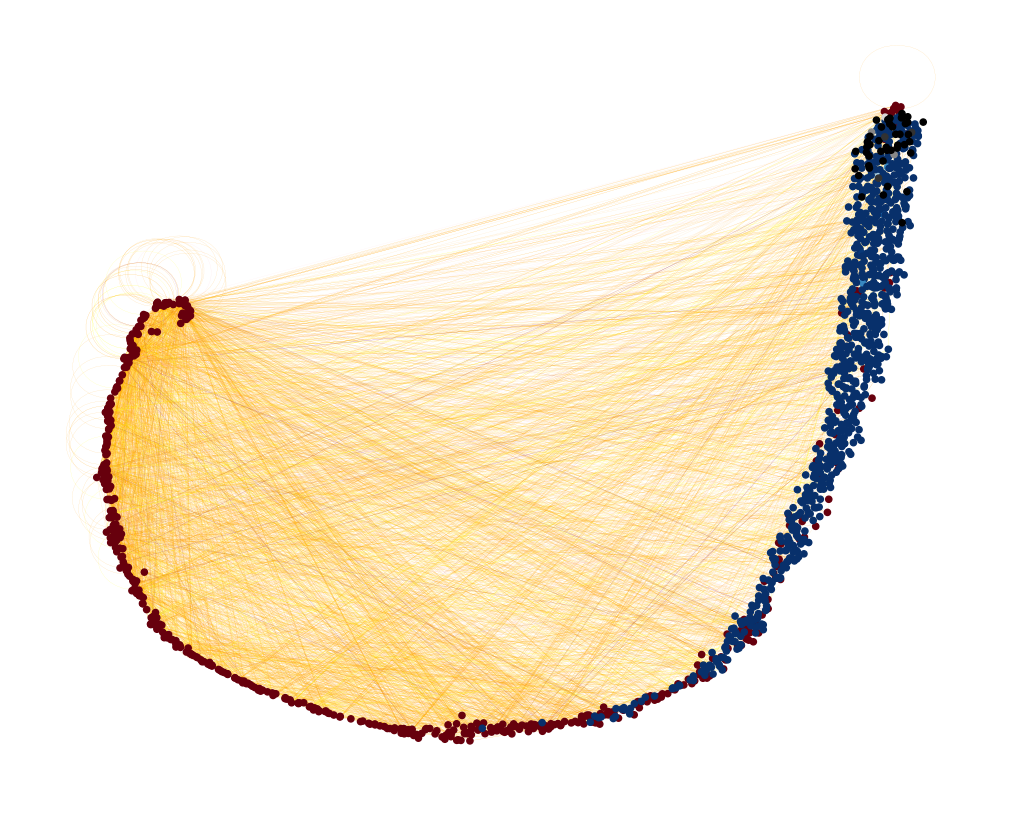

In [27]:
# Plotting using networkx

geneGraph2 = nx.Graph()

# Assigning each node a position by its vector
for node, pos in umap_embeddings.items():
    node = int(node)
    geneGraph2.add_node(node, pos=pos)

# Finding missing nodes
missing_nodes = [node for node in geneGraph2.nodes() if node not in umap_embeddings.values()]

# Adding edges
edges = get_edges(walks)
geneGraph2.add_edges_from(edges)

edge_styles = edge_style(geneGraph2)
edge_colors = color_edge_section(geneGraph2)

print(len(edge_colors))
print(len(edge_styles))

# Assigning node attributes
pos = nx.get_node_attributes(geneGraph2, 'pos')

# Drawing graph
plt.figure(figsize=(10, 8))
nx.draw(geneGraph2, pos, with_labels=False, width = 0.1, node_color=node_colors_spectrum, edge_color=edge_colors, style=edge_styles, node_size=20)
plt.show()

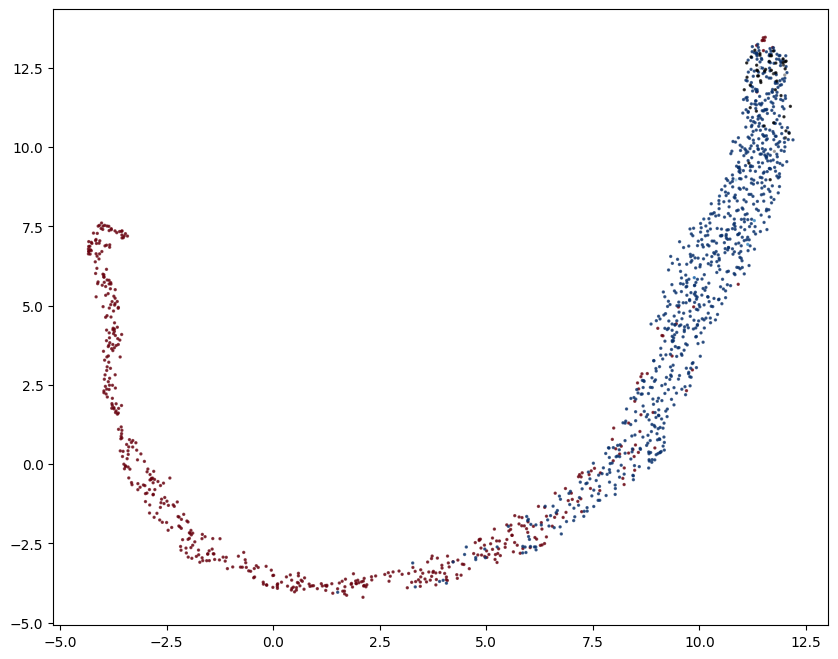

In [23]:
alpha = 0.7

plt.figure(figsize=(10, 8))
plt.scatter(
    umap_embeddings_2d[:, 0],
    umap_embeddings_2d[:, 1],
    s=2,
    c = node_colors_spectrum,
    alpha=alpha,
)

In [ ]:
# alpha = 0.7

# plt.figure(figsize=(10, 8))
# plt.scatter(
#     tsne_node_embeddings_2d[:, 0],
#     tsne_node_embeddings_2d[:, 1],
#     s=2,
#     c = node_colors,
#     alpha=alpha,
# )